In [1]:
import sys

sys.path.insert(0, '..')

## Setup the model area

In [2]:
from morpheus.project.types.discretization import SpatialDiscretization
from morpheus.project.types.discretization.spatial import Rotation, Grid, Crs
from morpheus.project.types.geometry import Polygon

polygon = Polygon(
  type='Polygon',
  coordinates=[[
    (13.92, 50.964),
    (13.92, 50.966),
    (13.925, 50.966),
    (13.925, 50.964),
    (13.92, 50.964)
  ]]
)

rotation = Rotation(0)

grid = Grid.cartesian_from_polygon(polygon=polygon, n_cols=100, n_rows=50, rotation=rotation)
spatial_discretization = SpatialDiscretization.from_geometry_with_grid(
  geometry=polygon,
  grid=grid,
  crs=Crs.from_str('EPSG:4326')
)

## Setup Time Discretization

In [3]:
from morpheus.project.types.discretization.time.TimeUnit import TimeUnit
from morpheus.project.types.discretization.time.Stressperiods import StartDateTime, StressPeriodCollection, \
  StressPeriod, NumberOfTimeSteps, TimeStepMultiplier, IsSteadyState
from morpheus.project.types.discretization.time import TimeDiscretization
from datetime import datetime

time_discretization = TimeDiscretization(
  start_date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
  end_date_time=StartDateTime.from_datetime(datetime(2020, 12, 31)),
  stress_periods=StressPeriodCollection([
    StressPeriod(
      start_date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
      number_of_time_steps=NumberOfTimeSteps(1),
      time_step_multiplier=TimeStepMultiplier(1),
      steady_state=IsSteadyState.yes()
    ),
  ]),
  time_unit=TimeUnit.days()
)

# Setup Model

In [4]:
from morpheus.project.types.Model import Model

model = Model.new()
model = model.with_updated_time_discretization(time_discretization)
model = model.with_updated_spatial_discretization(spatial_discretization=spatial_discretization)

In [5]:
import folium

m = folium.Map(tiles="cartodbpositron", crs="EPSG3857", zoom_start=12, location=[50.965, 13.922])
m.add_child(folium.GeoJson(polygon.as_geojson()))

m.fit_bounds(m.get_bounds())
m

# Setup Wells

In [6]:
from morpheus.project.types.boundaries.WellObservation import WellRawDataItem, PumpingRate
from morpheus.project.types.geometry import Point
from morpheus.project.types.boundaries.Boundary import BoundaryName, BoundaryCollection, WellBoundary

boundary_collection = BoundaryCollection.new()

well_boundary_1 = WellBoundary.from_geometry(
  name=BoundaryName('well_1'),
  geometry=Point((13.921, 50.965)),
  grid=grid,
  affected_layers=[model.layers[0].layer_id],
  data=[
    WellRawDataItem(
      date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
      pumping_rate=PumpingRate.from_float(-1000),
    ),
    WellRawDataItem(
      date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
      pumping_rate=PumpingRate.from_float(-1000),
    ),
  ]
)

well_boundary_2 = WellBoundary.from_geometry(
  name=BoundaryName('well_2'),
  geometry=Point((13.923, 50.9655)),
  grid=grid,
  affected_layers=[model.layers[0].layer_id],
  data=[
    WellRawDataItem(
      date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
      pumping_rate=PumpingRate.from_float(1000),
    ),
    WellRawDataItem(
      date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
      pumping_rate=PumpingRate.from_float(1000),
    ),
  ]
)

boundary_collection.add_boundary(well_boundary_1)
boundary_collection.add_boundary(well_boundary_2)

model = model.with_updated_boundaries(boundaries=boundary_collection)

m.add_child(folium.GeoJson(well_boundary_1.as_geojson()))
m.add_child(folium.GeoJson(well_boundary_1.affected_cells.to_geojson(grid).as_geojson()))
m.add_child(folium.GeoJson(well_boundary_2.as_geojson()))
m.add_child(folium.GeoJson(well_boundary_2.affected_cells.to_geojson(grid).as_geojson()))

m.fit_bounds(m.get_bounds())
m

In [7]:
from morpheus.project.infrastructure.calculation.engines.modflow_2005.packages.WelPackageMapper import \
  calculate_wel_boundary_stress_period_data

result = calculate_wel_boundary_stress_period_data(
  spatial_discretization=spatial_discretization,
  time_discretization=time_discretization,
  layers=model.layers,
  wel_boundary=well_boundary_1,
)
print(result.to_dict())

result = calculate_wel_boundary_stress_period_data(
  spatial_discretization=spatial_discretization,
  time_discretization=time_discretization,
  layers=model.layers,
  wel_boundary=well_boundary_2,
)
print(result.to_dict())

{0: [[0, 25, 19, -1000.0]]}
{0: [[0, 12, 59, 1000.0]]}


## Calculate

In [8]:
from morpheus.project.types.calculation.CalculationProfile import CalculationProfile, CalculationEngineType
from morpheus.project.types.calculation.Calculation import Calculation

calculation_profile = CalculationProfile.new(CalculationEngineType.MF2005)
calculation = Calculation.new(model=model, calculation_profile=calculation_profile)

In [9]:
model.layers[0].properties.to_dict()

{'hk': {'value': 1.0, 'raster': None, 'zones': None},
 'hani': {'value': 1.0, 'raster': None, 'zones': None},
 'vka': {'value': 1.0, 'raster': None, 'zones': None},
 'specific_storage': {'value': 0.0001, 'raster': None, 'zones': None},
 'specific_yield': {'value': 0.1, 'raster': None, 'zones': None},
 'initial_head': {'value': 1.0, 'raster': None, 'zones': None},
 'top': {'value': 1.0, 'raster': None, 'zones': None},
 'bottom': {'value': 0.0, 'raster': None, 'zones': None}}

In [10]:
calculation = Calculation.from_dict(calculation.to_dict())
calculation.calculation_id

CalculationId(value='6b203288-3eff-483c-98c1-5e6510b3e060')

In [11]:
from morpheus.project.infrastructure.calculation.services.CalculationService import CalculationService

calculation_service = CalculationService.from_calculation(calculation)
calculation_service.calculate()

Model(model_id=ModelId(value='7edb5195-37b1-4d88-bb41-f684e64ea99b'), spatial_discretization=SpatialDiscretization(geometry=Polygon(coordinates=[[(13.92, 50.964), (13.92, 50.966), (13.925, 50.966), (13.925, 50.964), (13.92, 50.964)]], type='Polygon'), grid=Grid(origin=Point(coordinates=(13.920000000000002, 50.965999999999994), type='Point'), col_widths=[5.565974539662712, 5.565974539662712, 5.565974539662712, 5.565974539662712, 5.565974539662712, 5.565974539662712, 5.565974539662712, 5.565974539662712, 5.5659745396627045, 5.565974539662719, 5.565974539662712, 5.565974539662712, 5.5659745396627045, 5.565974539662719, 5.5659745396627045, 5.565974539662719, 5.565974539662719, 5.56597453966269, 5.565974539662719, 5.565974539662719, 5.5659745396627045, 5.565974539662719, 5.565974539662719, 5.5659745396627045, 5.5659745396627045, 5.5659745396627045, 5.565974539662733, 5.5659745396627045, 5.5659745396627045, 5.5659745396627045, 5.5659745396627045, 5.565974539662733, 5.5659745396627045, 5.5659

In [12]:
result = calculation_service.get_result()
result

CalculationResult(type=<CalculationResultType.SUCCESS: 'success'>, message='Calculation finished successfully', files=['7edb5195-37b1-4d88-bb41-f684e64ea99b.dis', '7edb5195-37b1-4d88-bb41-f684e64ea99b.nam', '7edb5195-37b1-4d88-bb41-f684e64ea99b.bas', '7edb5195-37b1-4d88-bb41-f684e64ea99b.lpf', '7edb5195-37b1-4d88-bb41-f684e64ea99b.pcg', '7edb5195-37b1-4d88-bb41-f684e64ea99b.wel', '7edb5195-37b1-4d88-bb41-f684e64ea99b.hds', '7edb5195-37b1-4d88-bb41-f684e64ea99b.list', '7edb5195-37b1-4d88-bb41-f684e64ea99b.oc'], head_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=1, number_of_observations=0), drawdown_results=None, budget_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=0, number_of_observations=0), concentration_results=None)

In [13]:
head = calculation_service.read_head(0, 0)

In [14]:
import simplejson as json

json = json.dumps(head, ignore_nan=True)
json

'[[-2.0739998817443848, -2.069999933242798, -2.062000036239624, -2.0490000247955322, -2.0329999923706055, -2.013000011444092, -1.9880000352859497, -1.9589999914169312, -1.9259999990463257, -1.8880000114440918, -1.8459999561309814, -1.7990000247955322, -1.7480000257492065, -1.6920000314712524, -1.63100004196167, -1.565000057220459, -1.4950000047683716, -1.4190000295639038, -1.3389999866485596, -1.253000020980835, -1.1629999876022339, -1.0679999589920044, -0.9679999947547913, -0.8629999756813049, -0.753000020980835, -0.6380000114440918, -0.5189999938011169, -0.39500001072883606, -0.2669999897480011, -0.1340000033378601, 0.003000000026077032, 0.14300000667572021, 0.2879999876022339, 0.43700000643730164, 0.5889999866485596, 0.7440000176429749, 0.902999997138977, 1.065000057220459, 1.2300000190734863, 1.3969999551773071, 1.565999984741211, 1.7380000352859497, 1.9110000133514404, 2.0850000381469727, 2.259999990463257, 2.436000108718872, 2.609999895095825, 2.7839999198913574, 2.95700001716613

In [15]:
calculation_service.read_drawdown(0, 0)

[]

In [16]:
calculation_service.read_budget(0, False)

{'STORAGE_IN': 0.0,
 'CONSTANT_HEAD_IN': 0.0,
 'WELLS_IN': 365000.0,
 'TOTAL_IN': 365000.0,
 'STORAGE_OUT': -0.0,
 'CONSTANT_HEAD_OUT': -0.0,
 'WELLS_OUT': -365000.0,
 'TOTAL_OUT': -365000.0,
 'IN-OUT': 0.0,
 'PERCENT_DISCREPANCY': 0.0,
 'tslen': 365.0}

In [17]:
calculation_service.read_budget(0, True)

{'STORAGE_IN': 0.0,
 'CONSTANT_HEAD_IN': 0.0,
 'WELLS_IN': 1000.0,
 'TOTAL_IN': 1000.0,
 'STORAGE_OUT': -0.0,
 'CONSTANT_HEAD_OUT': -0.0,
 'WELLS_OUT': -1000.0,
 'TOTAL_OUT': -1000.0,
 'IN-OUT': 0.0,
 'PERCENT_DISCREPANCY': 0.0,
 'tslen': 365.0}

In [18]:
calculation_service.get_result()

CalculationResult(type=<CalculationResultType.SUCCESS: 'success'>, message='Calculation finished successfully', files=['7edb5195-37b1-4d88-bb41-f684e64ea99b.dis', '7edb5195-37b1-4d88-bb41-f684e64ea99b.nam', '7edb5195-37b1-4d88-bb41-f684e64ea99b.bas', '7edb5195-37b1-4d88-bb41-f684e64ea99b.lpf', '7edb5195-37b1-4d88-bb41-f684e64ea99b.pcg', '7edb5195-37b1-4d88-bb41-f684e64ea99b.wel', '7edb5195-37b1-4d88-bb41-f684e64ea99b.hds', '7edb5195-37b1-4d88-bb41-f684e64ea99b.list', '7edb5195-37b1-4d88-bb41-f684e64ea99b.oc'], head_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=1, number_of_observations=0), drawdown_results=None, budget_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=0, number_of_observations=0), concentration_results=None)

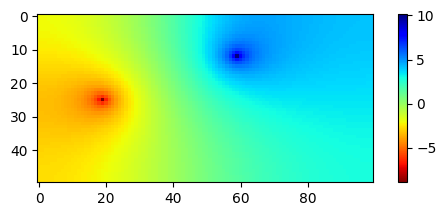

In [19]:
import matplotlib.pyplot as plt

heads = calculation_service.read_head(0, 0)
plt.subplot(2, 1, 1)
plt.imshow(heads, cmap='jet_r')
plt.colorbar()
plt.show()